In [1]:
import tensorflow as tf
import numpy as np

In [2]:
print(tf.__version__)

2.7.0


# 텐서의 차원과 연산

In [3]:
a = tf.constant(2)
print(tf.rank(a))
print(a)

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)


In [4]:
b = tf.constant([2,3])
print(tf.rank(b))
print(b)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor([2 3], shape=(2,), dtype=int32)


# 난수 생성

In [5]:
rand =tf.random.uniform([1], 0,1)
print(rand.shape)
print(rand)

(1,)
tf.Tensor([0.04194868], shape=(1,), dtype=float32)


In [6]:
rand2 = tf.random.normal([1,2], 0, 1)
print(rand2.shape)

(1, 2)


In [7]:
rand3 = tf.random.normal(shape = (3,2), mean = 0, stddev= 1)
print(rand3)

tf.Tensor(
[[ 0.19087581  0.17960599]
 [ 2.3016808   0.25460425]
 [-1.2746159  -1.0025935 ]], shape=(3, 2), dtype=float32)


# 즉시 실행 모드 지원

In [8]:
a = tf.constant(3)
b = tf.constant(2)

In [9]:
print(tf.add(a, b))
print(a + b)

tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)


# tensorflow <-> numpy
* tf.convert_to_tensor()

In [10]:
c = tf.add(a, b).numpy()
print(type(c))

<class 'numpy.int32'>


In [11]:
c_square = np.square(c, dtype = np.float32)
c_tensor = tf.convert_to_tensor(c_square)
print(c_tensor)

tf.Tensor(25.0, shape=(), dtype=float32)


# numpy 처럼 사용하기

In [12]:
t= tf.constant([[1.,2.,3.], [4.,5.,6.]])

print(t.shape)
print(t.dtype)

(2, 3)
<dtype: 'float32'>


In [13]:
print(t[:, 1:])

tf.Tensor(
[[2. 3.]
 [5. 6.]], shape=(2, 2), dtype=float32)


In [14]:
t[...,1 , tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

# 타입의 변환
* 텐서의 기본 dtype : int32, flaot32
* tf.cast()

In [15]:
a = tf.constant(2)
b = tf.constant(2.)

print(a)
print(b)

tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(2.0, shape=(), dtype=float32)


In [16]:
tf.constant(2.)+ tf.constant(3.)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

In [17]:
t = tf.constant(30., dtype = tf.float64)
t2= tf.constant(4.)

print(t2 + tf.cast(t, tf.float32))

tf.Tensor(34.0, shape=(), dtype=float32)


# AutoGraph
* tf.graph

In [18]:
import timeit

## @tf.function
* 자동으로 그래프 생성
* 원본 함수가 필요하다면(tf.function).python_function()

In [19]:
@tf.function
def solution(x):
  return x**2 - 10*x +3

print(solution(2))
print(solution(tf.constant(2)))

tf.Tensor(-13, shape=(), dtype=int32)
tf.Tensor(-13, shape=(), dtype=int32)


In [20]:
def solution_(x):
  return x**2 -10*x+3

print(solution_(2))
print(solution(tf.constant(2)))

-13
tf.Tensor(-13, shape=(), dtype=int32)


In [21]:
tf_sol = tf.function(solution_)
print(tf_sol)
print(tf_sol(2))

tf.Tensor(-13, shape=(), dtype=int32)


In [22]:
def function_to_get_faster(x,y,b):
  x = tf.matmul(x, y)
  x = x+b
  return x
a_function_that_uses_a_graph = tf.function(function_to_get_faster)

x1 = tf.constant([[1.0,2.0]])
y1 = tf.constant([[2.0],[3.0]])
b1= tf.constant(4.0)

a_function_that_uses_a_graph(x1, y1, b1).numpy()

array([[12.]], dtype=float32)

### tensorflow가 tf.function으로 변환한 코드

In [23]:
print(tf.autograph.to_code(tf_sol.python_function))

def tf__solution_(x):
    with ag__.FunctionScope('solution_', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        try:
            do_return = True
            retval_ = (((ag__.ld(x) ** 2) - (10 * ag__.ld(x))) + 3)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



### 속도 향상

In [24]:
class SequentialModel(tf.keras.Model):
  def __init__(self, **kwargs):
    super(SequentialModel, self).__init__(**kwargs)
    self.flatten = tf.keras.layers.Flatten(input_shape = (28, 28))
    self.dense_1 = tf.keras.layers.Dense(128, activation = 'relu')
    self.dropout = tf.keras.layers.Dropout(0.2)
    self.dense_2 = tf.keras.layers.Dense(10)

  def call(self, x):
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.dropout(x)
    x = self.dense_2(x)
    return x

input_data = tf.random.uniform([60,28,28])

eager_model = SequentialModel()
graph_model = tf.function(eager_model)


print('Eager time:', timeit.timeit(lambda : eager_model(input_data), number =10000))
print('Graph time:', timeit.timeit(lambda : graph_model(input_data), number =10000))

Eager time: 10.637215923000042
Graph time: 3.0239947270000016


# 변수 생성
* tf.variable
* 딥러닝 모델 학습 시, 그래프 연산이 필요할때 사용

In [25]:
x = tf.Variable(20.0)
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=20.0>


## Autograd(자동미분)

In [26]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
  y = x ** 2 

In [27]:
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

In [28]:
x2= tf.Variable(4)
y = tf.Variable(3.0)

with tf.GradientTape() as tape:
  y_sq = y**2
  z = x**2 + tf.stop_gradient(y_sq)

grad = tape.gradient(z, {'x':x, 'y':y})
grad['x']

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [29]:
weights = tf.Variable(tf.random.normal((3,2)), name = 'weights')
biases = tf.Variable(tf.zeros(2, dtype = tf.float32), name = 'biases')

x = [[1,2,3]]

with tf.GradientTape(persistent = True) as tape:
  y = x @ weights + biases 
  loss = tf.reduce_mean(y**2)


In [30]:
[dl_dw, dl_db] = tape.gradient(loss, [weights , biases])

In [31]:
print(weights.shape)
print(dl_dw.shape)

(3, 2)
(3, 2)


In [32]:
weights2 = tf.Variable(tf.random.normal((3,2)), name = 'weights')
biases2= tf.Variable(tf.zeros(2, dtype = tf.float32), name = 'biases')

x2 = [[4.,5.,6.]]

[dl_dw2, dl_db2] = tape.gradient(loss, [weights2 , biases2])

print(weights2.shape)
print(dl_dw.shape)

(3, 2)
(3, 2)


In [33]:
del tape

# 뉴런
* 입력 -> 연산 ->활성화함수 -> 출력

In [34]:
def sigmoid(x):
  return(1 /(1 + np.exp(-x)))

def Neuron(x, W, bias = 0):
  z = x*W +bias 
  return sigmoid(z)

In [36]:
x = tf.random.normal((1,2), 0, 1)
W = tf.random.normal((1,2),0,1)

print(x.shape)
print(W.shape)

print(x)
print(W)

print(Neuron(x,W))

(1, 2)
(1, 2)
tf.Tensor([[-1.341008   -0.00253729]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.04753911  0.20278384]], shape=(1, 2), dtype=float32)
[[0.5159322 0.4998714]]


## 퍼셉트론 학습 알고리즘(가중치 업데이트)


In [42]:
x = 1
y = 0

W = tf.random.normal([1], 0, 1)
print(Neuron(x, W))
print(y)

[0.25046453]
0


In [43]:
for i in range(1000):
  output = Neuron(x, W)
  error = y - output
  W = W + x*0.1 * error

  if i %100 == 99:
    print("{}\t{}\t{}".format(i+1, error, output))

100	[-0.0793919]	[0.0793919]
200	[-0.04539573]	[0.04539573]
300	[-0.03157634]	[0.03157634]
400	[-0.02415054]	[0.02415054]
500	[-0.01953106]	[0.01953106]
600	[-0.01638525]	[0.01638525]
700	[-0.01410714]	[0.01410714]
800	[-0.01238231]	[0.01238231]
900	[-0.01103151]	[0.01103151]
1000	[-0.00994533]	[0.00994533]


In [44]:
def Neuron2(x, W, bias = 0):  
  z = tf.matmul(x, W, transpose_b = True) + bias
  return sigmoid(z)

In [45]:
x = tf.random.normal((1,3), 0, 1)
y = tf.ones(1)
W = tf.random.normal((1,3), 0, 1)

print(Neuron2(x, W))
print(y)


[[0.64479536]]
tf.Tensor([1.], shape=(1,), dtype=float32)


In [46]:

for i in range(1000):
  output = Neuron2(x, W)
  error = y - output
  W = W + x*0.1 * error

  if i %100 == 99:
    print("{}\t{}\t{}".format(i+1, error, output))

100	[[0.02073914]]	[[0.97926086]]
200	[[0.01040226]]	[[0.98959774]]
300	[[0.00693142]]	[[0.9930686]]
400	[[0.00519484]]	[[0.99480516]]
500	[[0.00415319]]	[[0.9958468]]
600	[[0.00345927]]	[[0.9965407]]
700	[[0.00296366]]	[[0.99703634]]
800	[[0.00259227]]	[[0.99740773]]
900	[[0.00230354]]	[[0.99769646]]
1000	[[0.00207257]]	[[0.9979274]]


In [47]:
x = tf.random.normal((1,3), 0, 1)
weights = tf.random.normal((1,3),0,1)
bias = tf.zeros((1,1))

y = tf.ones((1,))

print(x)
print(weights)
print(bias)

tf.Tensor([[-0.8507938  -0.23130432  0.93916726]], shape=(1, 3), dtype=float32)
tf.Tensor([[-0.82499015 -0.36134505 -0.5207907 ]], shape=(1, 3), dtype=float32)
tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


In [48]:
for i in range(1000):
  output = Neuron2(x, weights, bias = bias)
  error = y - output
  weights = weights +x *0.1*error
  bias = bias +1*0.1*error
  
  if i %100 == 99:
    print("{}\t{}\t{}".format(i+1, error, output))

100	[[0.03835702]]	[[0.961643]]
200	[[0.01921386]]	[[0.98078614]]
300	[[0.01277477]]	[[0.98722523]]
400	[[0.00955856]]	[[0.99044144]]
500	[[0.00763267]]	[[0.9923673]]
600	[[0.00635129]]	[[0.9936487]]
700	[[0.00543755]]	[[0.99456245]]
800	[[0.00475317]]	[[0.9952468]]
900	[[0.00422168]]	[[0.9957783]]
1000	[[0.00379688]]	[[0.9962031]]


## AND GATE

In [49]:
x = np.array([[1,1],[1,0],[0,1],[0,0]])
y = np.array([[1],[0],[0],[1]])

W = tf.random.normal([2],0,1)
b = tf.random.normal([2],0,1)
b_x = 1

for i in range(1000):
  error_sum = 0
  
  for j in range(4):
    output = sigmoid(np.sum(x[j]*W) +b_x +b)
    error = y[j][0] - output
    W = W + x[j] * 0.1 *error
    b = b+ b_x*0.1* error
    error_sum += error

  if i % 200 == 0:
    print('Epoch {:4d}\tError Sum {}'.format(i, error_sum))
print('가중치 : {}'.format(W))
print('편향 : {}'.format(b))

Epoch    0	Error Sum [-1.1248379 -1.7592099]
Epoch  200	Error Sum [-0.00337273 -0.00337273]
Epoch  400	Error Sum [-0.00013691 -0.00013691]
Epoch  600	Error Sum [-5.543232e-06 -5.543232e-06]
Epoch  800	Error Sum [-4.7683716e-07 -4.7683716e-07]
가중치 : [-5.1282883e-02 -1.1511147e-06]
편향 : [-0.9999984 -0.9999984]


In [50]:
for i in range(4):
  print('X : {} Y :{} output:{}'.format(x[i], y[i], sigmoid(np.sum(x[i]*W)+b)))

X : [1 1] Y :[1] output:[0.25897893 0.25897893]
X : [1 0] Y :[0] output:[0.25897914 0.25897914]
X : [0 1] Y :[0] output:[0.26894152 0.26894152]
X : [0 0] Y :[1] output:[0.26894173 0.26894173]


## OR GATE

In [51]:
x2 = np.array([[1,1],[1,0],[0,1],[0,0]])
y2 = np.array([[1],[0],[0],[1]])
W2 = tf.random.normal([2],0,1)
b2 = tf.random.normal([2],0,1)
b_x = 1

for i in range(1000):
  error_sum = 0
  
  for j in range(4):
    output = sigmoid(np.sum(x2[j]*W2) + b_x +b2)
    error = y2[j][0] - output
    W2 = W2 + x2[j] * 0.1 * error
    b2 = b2 + b_x * 0.1* error
    error_sum += error

  if i % 200 == 0:
    print('Epoch {:4d}/tError Sum {}'.format(i, error_sum)) 
print('가중치 : {}'.format(W2))
print('편향 : {}'.format(b2))

Epoch    0/tError Sum [-1.1748734 -1.0629148]
Epoch  200/tError Sum [0.00306439 0.00306439]
Epoch  400/tError Sum [0.00012457 0.00012457]
Epoch  600/tError Sum [4.827976e-06 4.827976e-06]
Epoch  800/tError Sum [4.172325e-07 4.172325e-07]
가중치 : [-5.1280484e-02  1.2516975e-06]
편향 : [-1.0000018 -1.0000018]


In [52]:
for i in range(4):
  print('X : {} Y :{} output:{}'.format(x2[i], y2[i], sigmoid(np.sum(x2[i]*W2)+b2)))

X : [1 1] Y :[1] output:[0.2589792 0.2589792]
X : [1 0] Y :[0] output:[0.25897896 0.25897896]
X : [0 1] Y :[0] output:[0.2689413 0.2689413]
X : [0 0] Y :[1] output:[0.26894107 0.26894107]


## XOR GATE

In [53]:
x3 = np.array([[1,1],[1,0],[0,1],[0,0]])
y3 = np.array([[0],[0],[0],[1]])
W3 = tf.random.normal([2],0,1)
b3 = tf.random.normal([2],0,1)
b_x = 1

for i in range(1000):
  error_sum = 0
  
  for j in range(4):
    output = sigmoid(np.sum(x3[j]*W3) + b_x +b3)
    error = y3[j][0] - output
    W3 = W3 + x3[j] * 0.1 * error
    b3 = b3 + b_x * 0.1* error
    error_sum += error

  if i % 200 == 0:
    print('Epoch {:4d}/tError Sum {}'.format(i, error_sum)) 
print('가중치 : {}'.format(W3))
print('편향 : {}'.format(b3))

Epoch    0/tError Sum [-2.4422479 -1.1448438]
Epoch  200/tError Sum [0.0453787  0.04542613]
Epoch  400/tError Sum [0.02467012 0.02467037]
Epoch  600/tError Sum [0.01683421 0.01683421]
Epoch  800/tError Sum [0.01273451 0.01273451]
가중치 : [-6.8234167 -6.825189 ]
편향 : [1.9388806 1.9388806]


In [54]:
for i in range(4):
  print('X : {} Y :{} output:{}'.format(x3[i], y3[i], sigmoid(np.sum(x3[i]*W3)+b3)))

X : [1 1] Y :[0] output:[8.21349e-06 8.21349e-06]
X : [1 0] Y :[0] output:[0.00750587 0.00750587]
X : [0 1] Y :[0] output:[0.00749267 0.00749267]
X : [0 0] Y :[1] output:[0.87422913 0.87422913]


In [58]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

np.random.seed(111)

X4 = np.array([[1,1],[1,0],[0,1],[0,0]])
Y4  = np.array([[0],[1],[1],[0]])

model = Sequential([Dense(units = 2, activation = 'sigmoid', input_shape = (2,)),
                    Dense(units = 1, activation = 'sigmoid')])
model.compile(optimizer = tf.keras.optimizers.SGD(lr = 0.1), loss = 'mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 2)                 6         
                                                                 
 dense_5 (Dense)             (None, 1)                 3         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [61]:
history = model.fit(X4, Y4, epochs = 3000, batch_size = 1, verbose = 0)

In [62]:
model.predict(X4)

array([[0.04347371],
       [0.9524055 ],
       [0.94546247],
       [0.04968887]], dtype=float32)

# 시각화 사용

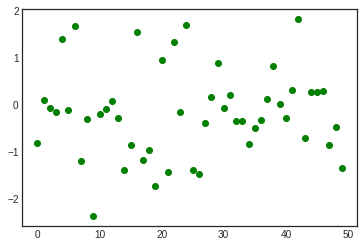

In [66]:
import matplotlib.pyplot as plt
plt.style.use(['seaborn-white'])

x = range(50)
y = tf.random.normal([50], 0, 1)
plt.plot(x, y, 'go')
plt.show()

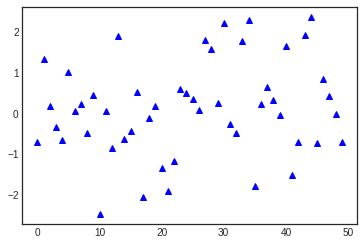

In [67]:
x = range(50)
y = tf.random.normal([50], 0, 1)
plt.plot(x, y, 'b^')
plt.show()

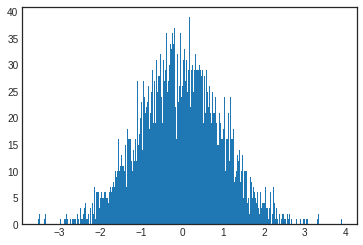

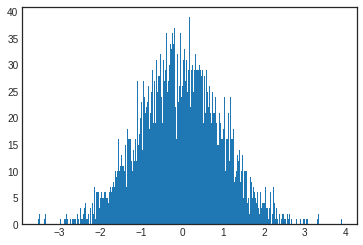

In [69]:
random_normal = tf.random.normal([10000], 0, 1)
plt.hist(random_normal, bins = 1000)
plt.show()

## XOR GATE의 시각화

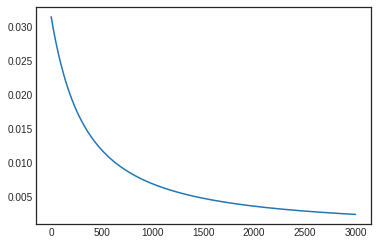

In [70]:
plt.plot(history.history['loss'])